In [1]:
import os, sys
path_name= os.path.dirname(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(path_name)
print(path_name)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine


In [2]:
from _element import feature_control as ft_c
from _element.data_control import Data, DataRestruction, DataAddition
from _element import varr
from _element import calculations as calc
from _element.result_control import Result

from _alg.prophet import Prophet_timeseries
from _alg.arima import Arima_timeseries

from _evaluation.cross_validation import Cross_Validation
from _evaluation import compare

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import fftconvolve
from statsmodels.tsa.stattools import ccf, pacf
from sklearn.mixture import GaussianMixture

import copy

In [4]:
df_in= ft_c.xlsx_opener('KPP일별입고(13_17)_daily_obj.xlsx')
df_return= ft_c.xlsx_opener('KPP일별회수(13_17)_daily_obj.xlsx')

In [5]:
df_in.tail()

,ds,1025,1041,1057,1091,1111,1117,1119,1127,1163,...,1754,1797,1800,1815,1817,1852,1853,1878,1891,y_sum
1790,2017-11-26,0,0,0,0,0,0,0,0,0,...,0,0,0,100,0,0,0,0,0,100
1791,2017-11-27,0,4866,489,448,0,0,416,0,0,...,480,0,0,75686,224,0,5417,5513,0,117480
1792,2017-11-28,0,5723,846,0,0,0,633,0,0,...,750,0,0,77009,224,0,7159,6178,0,122192
1793,2017-11-29,0,6732,0,416,0,0,990,0,0,...,670,0,0,77341,224,0,4847,5062,0,120685
1794,2017-11-30,0,6909,254,596,0,0,160,0,0,...,0,18,0,68600,0,0,5586,4166,0,108386


In [6]:
data= Data()
data.setRawData(df_return, dataname= 'return')
data.addData(df_in, dataname= 'in')

          ds  1025  1032  1041  1057  1064  1091  1101  1117  1119  ...    \
0 2013-01-01     0     0    81     0     0     0     0     0     0  ...     
1 2013-01-02     0     0   326     0     0     1     0     0     0  ...     
2 2013-01-03     0     0   312     0     0     0     0     0     0  ...     
3 2013-01-04     0     0   586     0     0     2     0     0     0  ...     
4 2013-01-05     0     0   218     0     0     0     0     0     0  ...     

   1797  1800   1815  1817  1818  1852  1853  1878  1891  y_sum  
0     0     0   7681     0     0     0     0     0     0   8374  
1     1     0  20876     0     0     0   100   181     0  26423  
2     1     0  22693     0     0     0   259   241     0  28156  
3    94     0  22571     0     0     0   252   455     2  29636  
4     0     0  21062     0     0     0  1150   211     2  27707  

[5 rows x 40 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 40 columns):
ds       17

In [7]:
restruct= DataRestruction(data)
region_condition= {
    'weekday': (0,1,2,3,4),
    'sat': (5, ),
    'sun': (6, )
}
restruct.divideRegion(7, 'weekday', start_num= 1, region_condition= region_condition)


In [8]:
restruct.selectSpecificY([1261])

In [9]:
restruct.data

{frozenset({'return', 'weekday'}):       1261         ds
 0      584 2013-01-01
 1     1129 2013-01-02
 2     1682 2013-01-03
 3     1880 2013-01-04
 6     2631 2013-01-07
 7     1956 2013-01-08
 8     1721 2013-01-09
 9     2013 2013-01-10
 10    2168 2013-01-11
 13    2541 2013-01-14
 14    2523 2013-01-15
 15    1924 2013-01-16
 16    3114 2013-01-17
 17    2102 2013-01-18
 20    2017 2013-01-21
 21    2101 2013-01-22
 22    2129 2013-01-23
 23    2475 2013-01-24
 24    2227 2013-01-25
 27    1522 2013-01-28
 28    1978 2013-01-29
 29    1695 2013-01-30
 30    3719 2013-01-31
 31    1998 2013-02-01
 34    2004 2013-02-04
 35    1855 2013-02-05
 36    2028 2013-02-06
 37    2121 2013-02-07
 38    1924 2013-02-08
 41      66 2013-02-11
 ...    ...        ...
 1753   544 2017-10-20
 1756  1025 2017-10-23
 1757  1010 2017-10-24
 1758  1387 2017-10-25
 1759   992 2017-10-26
 1760  1597 2017-10-27
 1763  1936 2017-10-30
 1764   981 2017-10-31
 1765   781 2017-11-01
 1766  1184 2017-11-02


In [10]:
restruct.deleteCase('sat')
restruct.deleteCase('sun')

In [11]:
restruct.setComparisonCase(frozenset({'return', 'weekday'}))

In [12]:
df_in_shift= restruct.data[frozenset({'in', 'weekday'})]

In [13]:
df_in_shift[1261]= df_in_shift[1261].shift(36)

In [14]:
restruct.data[frozenset({'return', 'weekday'})]= restruct.data[frozenset({'return', 'weekday'})].iloc[37:].merge(df_in_shift[37:], on= 'ds', how= 'left', suffixes= ('_y', '_shift37'))

In [15]:
restruct.deleteCase('in')

In [16]:
df_commit= restruct.commitRestructedData()

   1261_y         ds  1261_shift37
0    2264 2013-02-21        3657.0
1    3393 2013-02-22        3112.0
2    3212 2013-02-25        4438.0
3    2825 2013-02-26        3834.0
4    4368 2013-02-27        3873.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246 entries, 0 to 1245
Data columns (total 3 columns):
1261_y          1246 non-null int64
ds              1246 non-null datetime64[ns]
1261_shift37    1246 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 38.9 KB
None
   1261         ds
0   584 2013-01-01
1  1129 2013-01-02
2  1682 2013-01-03
3  1880 2013-01-04
6  2631 2013-01-07
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 0 to 1794
Data columns (total 2 columns):
1261    1283 non-null int64
ds      1283 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 30.1 KB
None
original grabcase expired; please take another case as grabcase.


In [17]:
df_temp= ft_c.xlsx_opener('temp_data_merged.xlsx', path_name+varr.TEMP_DATA_DIR)
addition= DataAddition(data)
addition.addXData(df_temp)


In [18]:
addition.commitAddedData()

original grabcase expired; please take another case as grabcase.
   1261_y         ds  1261_shift37  temp_max  temp_min  rain_amount
0    2264 2013-02-21        3657.0       2.3      -3.6          4.0
1    3393 2013-02-22        3112.0       4.3      -4.3          0.0
2    3212 2013-02-25        4438.0       8.1       1.0          0.0
3    2825 2013-02-26        3834.0       7.3       0.9          0.0
4    4368 2013-02-27        3873.0       8.7      -0.9          0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246 entries, 0 to 1245
Data columns (total 6 columns):
1261_y          1246 non-null int64
ds              1246 non-null datetime64[ns]
1261_shift37    1246 non-null float64
temp_max        1246 non-null float64
temp_min        1246 non-null float64
rain_amount     1246 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 68.1 KB
None
   1261         ds  temp_max   temp_min  rain_amount
0   584 2013-01-01      -0.4 -12.900000          3.0
1  1129

In [19]:
restruct= DataRestruction(data)
restruct.deleteCase('ComparisonCase')
restruct.commitRestructedData()

   1261_y         ds  1261_shift37  temp_max  temp_min  rain_amount
0    2264 2013-02-21        3657.0       2.3      -3.6          4.0
1    3393 2013-02-22        3112.0       4.3      -4.3          0.0
2    3212 2013-02-25        4438.0       8.1       1.0          0.0
3    2825 2013-02-26        3834.0       7.3       0.9          0.0
4    4368 2013-02-27        3873.0       8.7      -0.9          0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246 entries, 0 to 1245
Data columns (total 6 columns):
1261_y          1246 non-null int64
ds              1246 non-null datetime64[ns]
1261_shift37    1246 non-null float64
temp_max        1246 non-null float64
temp_min        1246 non-null float64
rain_amount     1246 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 68.1 KB
None
original grabcase expired; please take another case as grabcase.


In [20]:
data_comparison= copy.deepcopy(data)

In [21]:
data.x_col.append('1261_shift37')

In [22]:
data.x_col

['temp_max', 'temp_min', 'rain_amount', '1261_shift37']

In [23]:
data.data

{frozenset({'return',
            'weekday'}):       1261_y         ds  1261_shift37   temp_max  temp_min  rain_amount
 0       2264 2013-02-21        3657.0   2.300000      -3.6          4.0
 1       3393 2013-02-22        3112.0   4.300000      -4.3          0.0
 2       3212 2013-02-25        4438.0   8.100000       1.0          0.0
 3       2825 2013-02-26        3834.0   7.300000       0.9          0.0
 4       4368 2013-02-27        3873.0   8.700000      -0.9          0.0
 5       3746 2013-02-28        3094.0  13.600000       0.3          4.0
 6        734 2013-03-01        2630.0   1.100000      -4.2          0.0
 7       2830 2013-03-04        3566.0   8.100000      -0.5          0.0
 8       3106 2013-03-05        3442.0   8.500000       1.0          0.0
 9       2524 2013-03-06        4649.0  14.000000       3.3          0.0
 10      2593 2013-03-07        3621.0   9.500000       3.9          0.0
 11      2494 2013-03-08        2560.0  13.600000       6.2          0.0
 12  

In [24]:
cv= Cross_Validation(data)
cv.slice('1261_y')

In [25]:
cv.commitRestructedData()

{frozenset({0,
            'weekday',
            'return'}):       1261_y         ds  1261_shift37   temp_max  temp_min  rain_amount
 0       2264 2013-02-21        3657.0   2.300000      -3.6          4.0
 1       3393 2013-02-22        3112.0   4.300000      -4.3          0.0
 2       3212 2013-02-25        4438.0   8.100000       1.0          0.0
 3       2825 2013-02-26        3834.0   7.300000       0.9          0.0
 4       4368 2013-02-27        3873.0   8.700000      -0.9          0.0
 5       3746 2013-02-28        3094.0  13.600000       0.3          4.0
 6        734 2013-03-01        2630.0   1.100000      -4.2          0.0
 7       2830 2013-03-04        3566.0   8.100000      -0.5          0.0
 8       3106 2013-03-05        3442.0   8.500000       1.0          0.0
 9       2524 2013-03-06        4649.0  14.000000       3.3          0.0
 10      2593 2013-03-07        3621.0   9.500000       3.9          0.0
 11      2494 2013-03-08        2560.0  13.600000       6.2    

In [26]:
cv= Cross_Validation(data_comparison)
cv.slice('1261_y')

In [27]:
cv.commitRestructedData()

{frozenset({0,
            'weekday',
            'return'}):       1261_y         ds  1261_shift37   temp_max  temp_min  rain_amount
 0       2264 2013-02-21        3657.0   2.300000      -3.6          4.0
 1       3393 2013-02-22        3112.0   4.300000      -4.3          0.0
 2       3212 2013-02-25        4438.0   8.100000       1.0          0.0
 3       2825 2013-02-26        3834.0   7.300000       0.9          0.0
 4       4368 2013-02-27        3873.0   8.700000      -0.9          0.0
 5       3746 2013-02-28        3094.0  13.600000       0.3          4.0
 6        734 2013-03-01        2630.0   1.100000      -4.2          0.0
 7       2830 2013-03-04        3566.0   8.100000      -0.5          0.0
 8       3106 2013-03-05        3442.0   8.500000       1.0          0.0
 9       2524 2013-03-06        4649.0  14.000000       3.3          0.0
 10      2593 2013-03-07        3621.0   9.500000       3.9          0.0
 11      2494 2013-03-08        2560.0  13.600000       6.2    

In [28]:
data.slicebyTrainTestStructure('1261_y')

In [29]:
data_comparison.slicebyTrainTestStructure('1261_y')

In [30]:
data_comparison.data

{frozenset({0,
            'weekday',
            'return'}): {'test':          y         ds  1261_shift37  temp_max  temp_min  rain_amount
  1241   731 2017-11-24           0.0       2.9      -2.5          0.1
  1242   771 2017-11-27         448.0       8.1       1.8          0.0
  1243   882 2017-11-28        1280.0       9.8       4.2          1.2
  1244  1183 2017-11-29        1158.0       5.7      -3.2          0.0
  1245   943 2017-11-30        1419.0       1.8      -7.1          0.0, 'testX':       temp_max  temp_min  rain_amount         ds
  1241       2.9      -2.5          0.1 2017-11-24
  1242       8.1       1.8          0.0 2017-11-27
  1243       9.8       4.2          1.2 2017-11-28
  1244       5.7      -3.2          0.0 2017-11-29
  1245       1.8      -7.1          0.0 2017-11-30, 'testY': 1241     731
  1242     771
  1243     882
  1244    1183
  1245     943
  Name: y, dtype: int64, 'train':          y         ds  1261_shift37   temp_max  temp_min  rain_amount
  0 

In [31]:
r= Result()

In [32]:
prophet_comp= Prophet_timeseries(data_comparison)
prophet_comp.addModel('comparison', 'day')

In [33]:
prophet_comp.fit('comparison')

In [34]:
prophet_comp.forecast('comparison', r.forecast_dict)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\feature_control.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ds'], box=True, format= '%Y/%m/%d', exact=True


In [35]:
prophet_addregressor= Prophet_timeseries(data)
prophet_addregressor.addModel('addregressor', 'day')

In [36]:
prophet_addregressor.fit('addregressor')

In [37]:
prophet_addregressor.forecast('addregressor', r.forecast_dict)

C:\Studying\Project_Nextop\nextop-engine\nextop_engine\_element\feature_control.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['ds'], box=True, format= '%Y/%m/%d', exact=True


In [38]:
r.forecast_dict

OrderedDict([(frozenset({0, 'weekday', 'return', 'comparison'}),
              {'forecast':       y         ds  1261_shift37  temp_max  temp_min  rain_amount         yhat
               0   731 2017-11-24           0.0       2.9      -2.5          0.1  1215.492606
               1   771 2017-11-27         448.0       8.1       1.8          0.0  1079.193227
               2   882 2017-11-28        1280.0       9.8       4.2          1.2  1253.305127
               3  1183 2017-11-29        1158.0       5.7      -3.2          0.0  1418.101451
               4   943 2017-11-30        1419.0       1.8      -7.1          0.0  1423.459738}),
             (frozenset({'weekday', 'return', 'comparison', 1}),
              {'forecast':       y         ds  1261_shift37   temp_max   temp_min  rain_amount  \
               0  1520 2017-09-15        2562.0  27.299999  17.200001          0.0   
               1  1125 2017-09-18        1332.0  27.100000  19.200001          0.0   
               2  151

In [39]:
r.calcErrRate()

In [40]:
r.printErrRate()

RMSE with segment 0,weekday,return,comparison: 388.2520
MAPE with segment 0,weekday,return,comparison: 43.8346
MAPE_with_std with segment 0,weekday,return,comparison: 29.3466
MAPE_div_std with segment 0,weekday,return,comparison: 387.0857
sMAPE with segment 0,weekday,return,comparison: 34.4886


RMSE with segment weekday,return,comparison,1: 308.6362
MAPE with segment weekday,return,comparison,1: 21.8814
MAPE_with_std with segment weekday,return,comparison,1: 11.2613
MAPE_div_std with segment weekday,return,comparison,1: 190.3435
sMAPE with segment weekday,return,comparison,1: 18.4535


RMSE with segment weekday,2,return,comparison: 443.1321
MAPE with segment weekday,2,return,comparison: 20.0110
MAPE_with_std with segment weekday,2,return,comparison: 27.2691
MAPE_div_std with segment weekday,2,return,comparison: 113.2390
sMAPE with segment weekday,2,return,comparison: 22.5531


RMSE with segment 3,weekday,return,comparison: 832.8434
MAPE with segment 3,weekday,return,comparison: 49.188

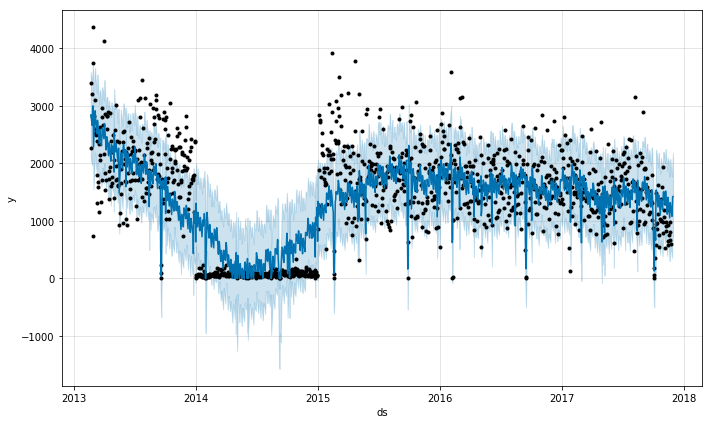

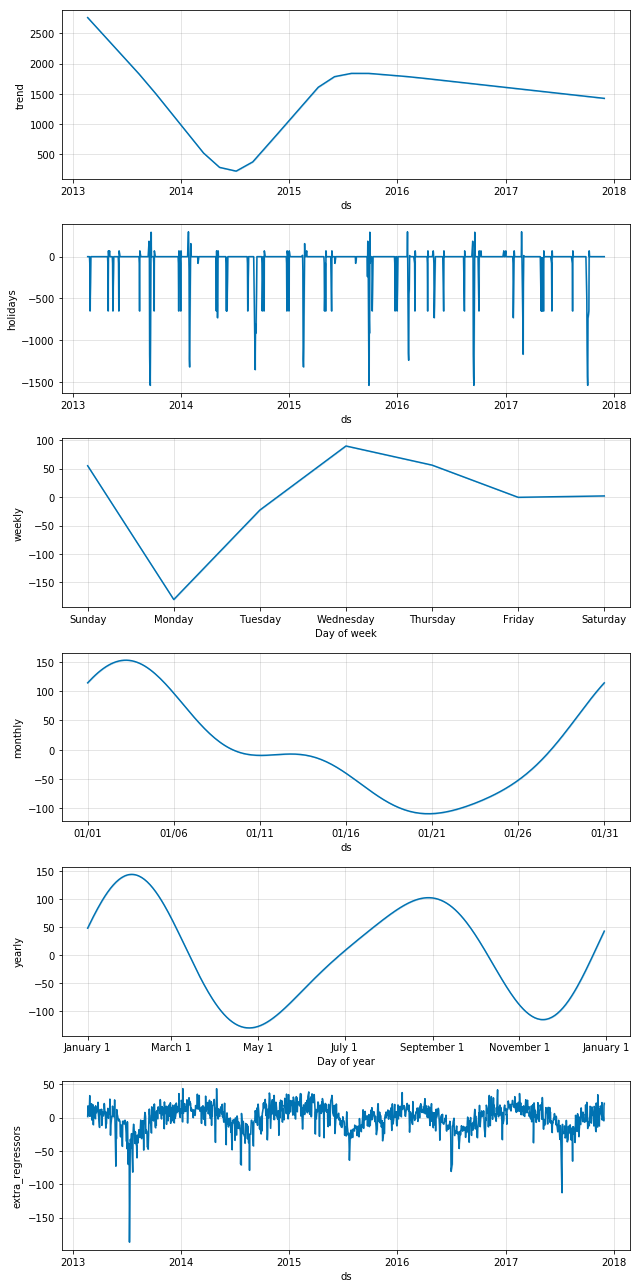

In [41]:
prophet_comp.plot(frozenset({'weekday',
            0,
            'return',
            'comparison'}))

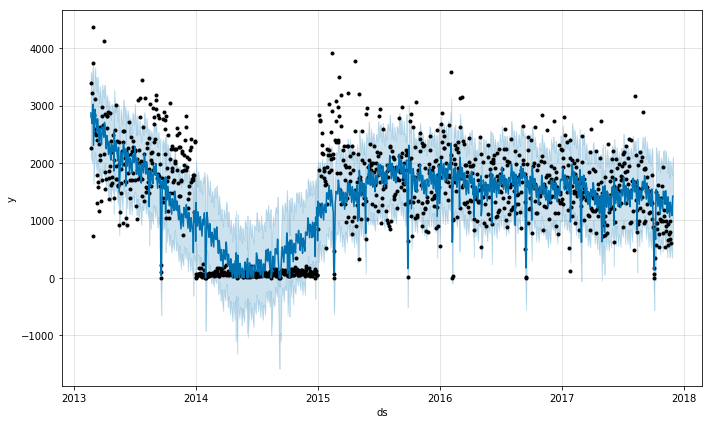

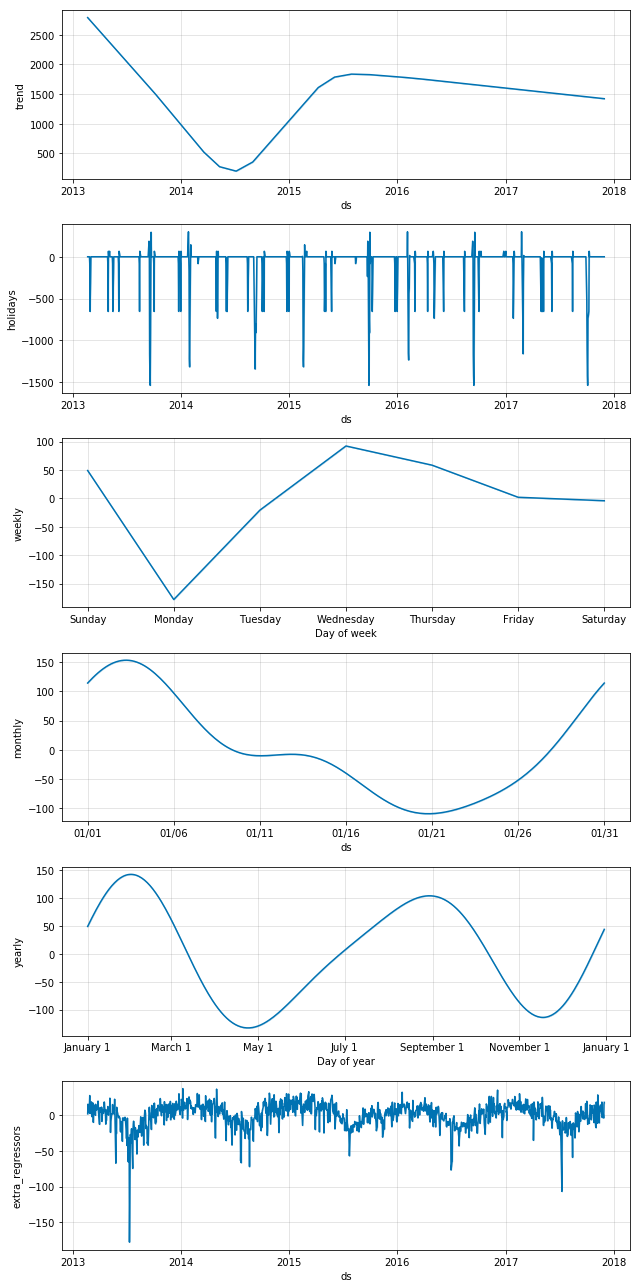

In [42]:
prophet_addregressor.plot(frozenset({'weekday',
            0,
            'return',
            'addregressor'}))

In [43]:
r.mergeResult(by= 'avg', m_name= 'addregressor')

In [44]:
r.forecast_dict

OrderedDict([(frozenset({0, 'weekday', 'return', 'comparison'}),
              {'MAPE': 43.83455679217024,
               'MAPE_div_std': 387.0857144257435,
               'MAPE_with_std': 29.346647237816004,
               'RMSE': 388.25195401936475,
               'forecast':       y         ds  1261_shift37  temp_max  temp_min  rain_amount         yhat
               0   731 2017-11-24           0.0       2.9      -2.5          0.1  1215.492606
               1   771 2017-11-27         448.0       8.1       1.8          0.0  1079.193227
               2   882 2017-11-28        1280.0       9.8       4.2          1.2  1253.305127
               3  1183 2017-11-29        1158.0       5.7      -3.2          0.0  1418.101451
               4   943 2017-11-30        1419.0       1.8      -7.1          0.0  1423.459738,
               'sMAPE': 34.488612419818892}),
             (frozenset({'weekday', 'return', 'comparison', 1}),
              {'MAPE': 21.881448224860527,
               'M